* Decision Trees: T/F 인지 뎁스를 깊이가면서 최적화된 값을 찾음. 장점 속도 빠르고, 시각화로 설명하기에 좋다는 알고리즘
* Random Forests 이런 decision trees의 장점을 모아 더 좋은 성늘을 내는것
* decision trees 끼리 투표를해서 결과를 예측하는게 

#### 얼마나 정확한지 평가하는게 측정시 Overfitting 과 Underfitting
###### 너무 특정한 상황에서만 맞고 , 일반화 하기 어려운

## 최적점을 찾는 과정이 중요하다.


RMSLE 로 

Load Dataset

In [24]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

mpl.rcParams['axes.unicode_minus'] = False

import warnings
warnings.filterwarnings('ignore')

In [2]:
train = pd.read_csv("train.csv", parse_dates=["datetime"])
train.shape

(10886, 12)

In [3]:
test= pd.read_csv("test.csv",parse_dates=["datetime"])
test.shape

(6493, 9)

## Feature Engineering

In [4]:
train["year"] = train["datetime"].dt.year
train["month"] = train["datetime"].dt.month
train["day"] = train["datetime"].dt.day
train["hour"] = train["datetime"].dt.hour
train["minute"] = train["datetime"].dt.minute
train["second"] = train["datetime"].dt.second
train["dayofweek"] = train["datetime"].dt.dayofweek
train.shape

(10886, 19)

In [5]:
test["year"] = test["datetime"].dt.year
test["month"] = test["datetime"].dt.month
test["day"] = test["datetime"].dt.day
test["hour"] = test["datetime"].dt.hour
test["minute"] = test["datetime"].dt.minute
test["second"] = test["datetime"].dt.second
test["dayofweek"] = test["datetime"].dt.dayofweek
test.shape

(6493, 16)

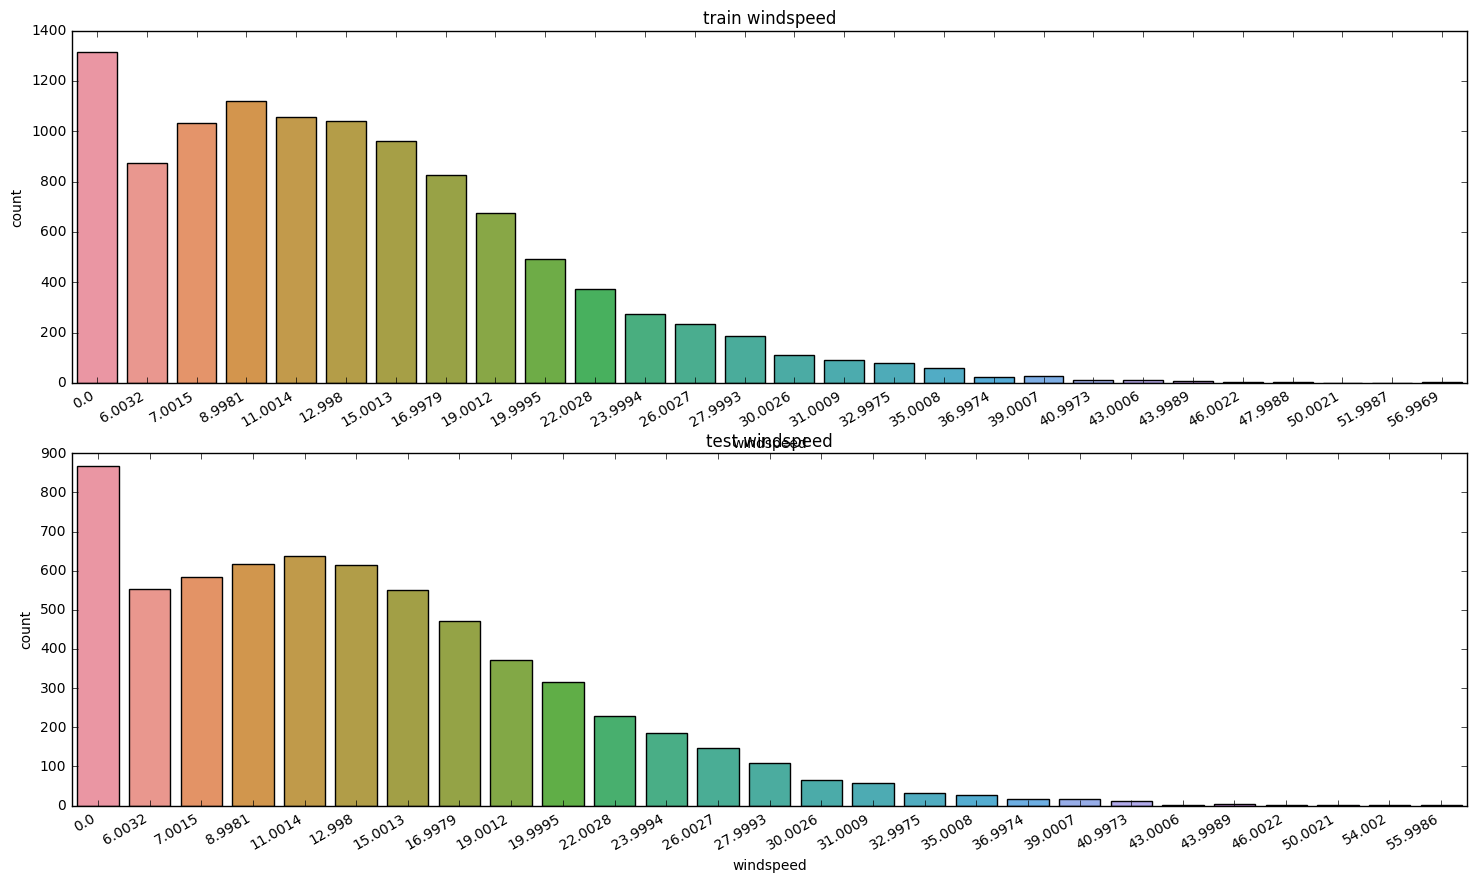

In [6]:
#Windspeed 풍속에 0값이 가장 많다 . -> 잘못 기록된 데이터를 고쳐줄 필요가 잇음
# => 자료를 가공하면 점수를 높이는데 도움이 되지 않을까 싶어. 가공해봤다.

fig, axes = plt.subplots(nrows=2)
fig.set_size_inches(18,10)

plt.sca(axes[0])
plt.xticks(rotation=30,ha='right')
axes[0].set(ylabel='Count',title="train windspeed")
sns.countplot(data=train , x= "windspeed", ax=axes[0])

plt.sca(axes[1])
plt.xticks(rotation = 30 , ha = 'right')
axes[1].set(ylabel = 'Count', title='test windspeed')
sns.countplot(data= test , x= "windspeed", ax=axes[1])

*  풍속의 0값에 특정 값을 넣어준다.
*  평균을 구해 일괄적으로 넣어줄 수도 있지만, 예측의 정확도를 높이는 데 도움이 될것 같진 않다.
*  train.loc[train["windspeed"] == 0, "windspeed"] = train["windspeed"].mean()
*  test.loc[train["windspeed"] == 0, "windspeed"] = train["windspeed"].mean()


In [7]:
trainWind0 = train.loc[train['windspeed'] == 0 ]
trainWindNot0 = train.loc[train['windspeed'] != 0]
print(trainWind0.shape)
print(trainWindNot0.shape)

(1313, 19)
(9573, 19)


In [8]:
#그래서 머신러닝으로 예측해서 풍속을 넣어주도록 한다.

from sklearn.ensemble import RandomForestClassifier

def predict_windspeed(data):
    #풍속이 0인것과 아닌 것을 나누어 준다.
    dataWind0 =data.loc[data['windspeed']== 0 ]
    dataWindNot0 = data.loc[data['windspeed'] != 0]
    
    #풍속을 예측할 피처를 선택한다.
    wCol = ['season','weather','humidity','month','temp','year','atemp']
    
    #풍속이 0이 아닌 데이터들의 타입을 스트링으로 바꿔준다.
    dataWindNot0["windspeed"] = dataWindNot0["windspeed"].astype("str")
    
    #랜덤포레스트 분류기를 사용한다.
    rfModel_wind = RandomForestClassifier()
    
    #wCol에 있는 피처의 값을 바탕으로 풍속을 학습시킨다.
    rfModel_wind.fit(dataWindNot0[wCol], dataWindNot0["windspeed"])
    
    #학습한 값을 바탕으로 풍속이 0으로 기록된 데이터의 풍속을 뎨측한다.
    wind0Values = rfModel_wind.predict(X = dataWind0[wCol])
    
    #값을 다 예측 후 비교해 보기 위해
    #예측한 값을 넣어 줄 데이터프레임을 새로 만든다.
    predictWind0 = dataWind0
    predictWindNot0 = dataWindNot0
    
    #값이 0으로 기록된 풍속에 대해 예측한 값을 넣어준다.
    predictWind0["windspeed"] = wind0Values
    
    #dataWindNot0 0이 아닌 풍속이 있는 데이터프레임에 예측한 값이 있는 데이터 프레임을 합쳐준다.
    data = predictWindNot0.append(predictWind0)
    
    #풍속의 데이터타입을 float으로 지정해준다.
    data["windspeed"] = data["windspeed"].astype("float")
    
    data.reset_index(inplace=True)
    data.drop('index',inplace = True, axis = 1)
    
    return data


# 그래서 머신러닝으로 예측을 해서 풍속을 넣어주도록 한다.
from sklearn.ensemble import RandomForestClassifier

def predict_windspeed(data):
    
    # 풍속이 0인것과 아닌 것을 나누어 준다.
    dataWind0 = data.loc[data['windspeed'] == 0]
    dataWindNot0 = data.loc[data['windspeed'] != 0]
    
    
    print(dataWind0)
    print(dataWindNot0)
    # 풍속을 예측할 피처를 선택한다.
    wCol = ["season", "weather", "humidity", "month", "temp", "year", "atemp"]

    # 풍속이 0이 아닌 데이터들의 타입을 스트링으로 바꿔준다.
    dataWindNot0["windspeed"] = dataWindNot0["windspeed"].astype("str")

    # 랜덤포레스트 분류기를 사용한다.
    rfModel_wind = RandomForestClassifier()

    print("=========================================")
    
    print(dataWindNot0[wCol])
    print("=========================================")
    
    print(dataWindNot0["windspeed"])
    # wCol에 있는 피처의 값을 바탕으로 풍속을 학습시킨다.
    rfModel_wind.fit(dataWindNot0[wCol], dataWindNot0["windspeed"])
    #rfModel_wind.fit(dataWindNot0[wCol], dataWindNot0["windspeed"], sample_weight=None)

    print("=========================================")
    print(rfModel_wind)
    # 학습한 값을 바탕으로 풍속이 0으로 기록 된 데이터의 풍속을 예측한다.
    wind0Values = rfModel_wind.predict(dataWind0[wCol])
    #wind0Values = rfModel_wind.predict(X = dataWind0[wCol])

    # 값을 다 예측 후 비교해 보기 위해
    # 예측한 값을 넣어 줄 데이터 프레임을 새로 만든다.
    predictWind0 = dataWind0
    predictWindNot0 = dataWindNot0

    # 값이 0으로 기록 된 풍속에 대해 예측한 값을 넣어준다.
    predictWind0["windspeed"] = wind0Values

    # dataWindNot0 0이 아닌 풍속이 있는 데이터프레임에 예측한 값이 있는 데이터프레임을 합쳐준다.
    data = predictWindNot0.append(predictWind0)

    # 풍속의 데이터타입을 float으로 지정해 준다.
    data["windspeed"] = data["windspeed"].astype("float")

    data.reset_index(inplace=True)
    data.drop('index', inplace=True, axis=1)
    
    return data

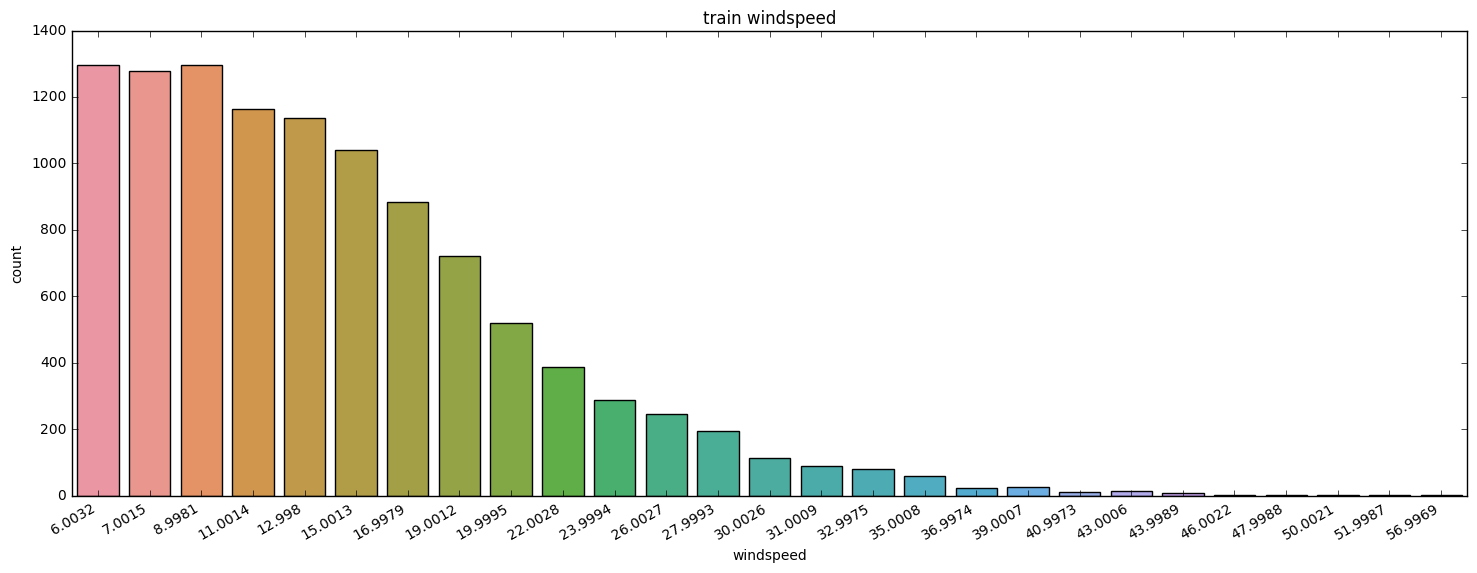

In [9]:
# 0값을 조정한다.
train = predict_windspeed(train)
#test = predict_windspeed(test)

#windpseed의 0값을 조정한 데이터를 시각화
fig , ax1 = plt.subplots()
fig.set_size_inches(18,6)

plt.sca(ax1)
plt.xticks(rotation=30,ha='right')
ax1.set(ylabel='Count',title='train windspeed')
sns.countplot(data=train,x="windspeed",ax=ax1)

# 0값을 조정한다.
train = predict_windspeed(train)
# test = predict_windspeed(test)

# widspeed 의 0값을 조정한 데이터를 시각화
fig, ax1 = plt.subplots()
fig.set_size_inches(18,6)

plt.sca(ax1)
plt.xticks(rotation=30, ha='right')
ax1.set(ylabel='Count',title="train windspeed")
sns.countplot(data=train, x="windspeed", ax=ax1)

## Feature Selection
* 신호와 잡음을 구분해야 한다.
* 피처가 많다고 해서 무조건 좋은 성능을 내진 않는다.
* 피처를 하나씩 추가하고 변경해 가면서 성능이 좋지 않은 피처는 제거하도록


In [10]:
#연속형 feature와 범주형 feature
# 연속형 feature = ["temp","humidity","windspeed","atemp"]
 # 수치형으로 연속해서 강도를 나타낼 수 있는것
#범주형 feature의 type을 category로 변경해준다.
 # 항목별 구분하는거
categorical_feature_names = ["season","holiday","workingday","weather","dayofweek","month","year","hour"]

for var in categorical_feature_names:
    train[var] = train[var].astype("category")
    test[var] = test[var].astype("category")
    

In [11]:
#feature 를 선택한다.
feature_names = ["season","weather","temp","atemp","humidity","windspeed","year","hour","dayofweek","holiday","workingday"]
feature_names

['season',
 'weather',
 'temp',
 'atemp',
 'humidity',
 'windspeed',
 'year',
 'hour',
 'dayofweek',
 'holiday',
 'workingday']

In [12]:
X_train = train[feature_names]
print(X_train.shape)
X_train.head()

(10886, 11)


,season,weather,temp,atemp,humidity,windspeed,year,hour,dayofweek,holiday,workingday
0,1,2,9.84,12.880,75,6.0032,2011,5,5,0,0
1,1,1,15.58,19.695,76,16.9979,2011,10,5,0,0
2,1,1,14.76,16.665,81,19.0012,2011,11,5,0,0
3,1,1,17.22,21.210,77,19.0012,2011,12,5,0,0
4,1,2,18.86,22.725,72,19.9995,2011,13,5,0,0


In [13]:
X_test = test[feature_names]
print(X_test.shape)

(6493, 11)


In [14]:
label_name="count"
y_train = train[label_name]
print(y_train.shape)
y_train.head()

(10886,)


0     1
1    36
2    56
3    84
4    94
Name: count, dtype: int64

# Score

## RMSLE
과대평가된 항목보다는 과소평가된 항목에 패널티를 준다.

오차(Error)를 제곱(Square)해 평균(Mean)한 값의 제곱근(Root)으로 값이 작을 수록 정밀도가 높다.

0에 가까운 값이 나올수록 정밀도가 높은 값이다.

submissions are evaluated one the Root mean squared logarithmic error (RMSLE)




In [15]:
from sklearn.metrics import make_scorer

def rmsle(predicted_values, actual_values):
    #넘파이로 배열 형태로 바꿔준다.
    predicted_values = np.array(predicted_values)
    actual_values = np.array(actual_values)
    
    #에측값과 실제 값에 1을 더하고 로그를 씌워준다.
    
    log_predict= np.log(predicted_values+1)
    log_actual = np.log(actual_values+1)
    
    
    #웨에서 계산한 예측값에서 실제값을 빼주고 제곱을 해준다.
    difference = log_predict - log_actual
    #difference = (log_predict - log_actual) **2
    difference = np.square(difference)
    
    #평균을 낸다.
     # 변수명 오타가 났었넹.
    mean_difference = difference.mean()
    
    
    #다시 루트를 씌운다.
    score = np.sqrt(mean_difference)
    return score

rmsle_scorer= make_scorer(rmsle)
rmsle_scorer
    

make_scorer(rmsle)

# Cross validation 교차검증

* 일반화 성능을 측정하기 위해 데이터를 여러번 반복해서 나누고 여러 모델을 학습한다.


In [16]:
from sklearn.model_selection import KFold
#from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

k_fold = KFold(n_splits= 10 , shuffle= True , random_state=0)

# RandomForest


In [17]:
from sklearn.ensemble import RandomForestRegressor

max_depth_list = []
# n_estimators 높을수록 좋은성능이 나오는데 높을수록 시간이 오래걸린다.
model = RandomForestRegressor(n_estimators=100,
                             n_jobs= 1,
                             random_state=0)
model

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
           oob_score=False, random_state=0, verbose=0, warm_start=False)

In [18]:
#%time score = cross_val_score(model, X_train,y_train,cv=k_fold,scoring=rmsle_scorer)
%time score = cross_val_score(model, X_train, y_train, cv=k_fold, scoring=rmsle_scorer)
score = score.mean()
#0에 근접할수록 좋은데이터

print("Score = {0:.5f}".format(score))


Wall time: 26.2 s
Score = 0.33061


# Train


In [19]:
#학습시킴, 피팅(옷을 맞출 때 사용하는 피팅을 생각함) - 피쳐와 레이블을 넣어주면 알아서 학습함
model.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
           oob_score=False, random_state=0, verbose=0, warm_start=False)

In [20]:
#예측
predictions = model.predict(X_test)
print(predictions.shape)
predictions[0:10]

(6493,)


array([  12.25,    5.16,    4.19,    3.5 ,    3.21,    6.19,   38.37,
        105.12,  233.72,  136.34])

In [44]:
type(y_train.values)
print(y_train.values)

[  1  36  56 ..., 662 132  41]


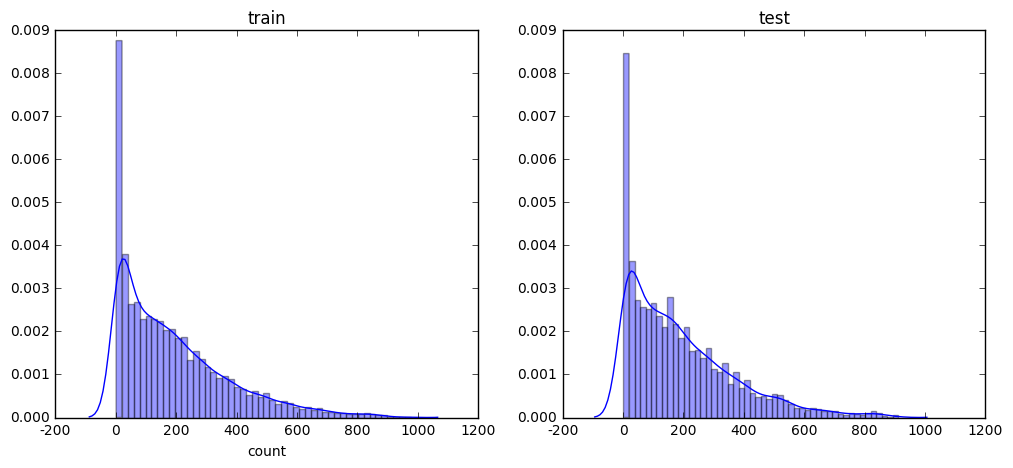

In [21]:
# 예측한 데이터를 시각화 해본다. 
fig,(ax1,ax2)= plt.subplots(ncols=2)
fig.set_size_inches(12,5)
sns.distplot(y_train,ax=ax1,bins=50)
ax1.set(title="train")
sns.distplot(predictions,ax=ax2,bins=50)
ax2.set(title="test")

# Submit


In [26]:
submission = pd.read_csv("sampleSubmission.csv")
submission

submission["count"] = predictions
print(submission.shape)
submission.head()

(6493, 2)


,datetime,count
0,2011-01-20 00:00:00,12.25
1,2011-01-20 01:00:00,5.16
2,2011-01-20 02:00:00,4.19
3,2011-01-20 03:00:00,3.50
4,2011-01-20 04:00:00,3.21


In [28]:
submission.to_csv("randomforest_score_{0:.5f}_submission.csv".format(score),index=False)